# Day 5: Nonlinear Least Squares (NLS)

---

- Example
- Math formulation
- Grama tools


In [1]:
import grama as gr

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from plotnine import *
DF = gr.Intention()

# Set figure options
plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower


## Example: Fitting a trajectory

---

Let's look at some "data" of a penny falling from the Empire State Building.


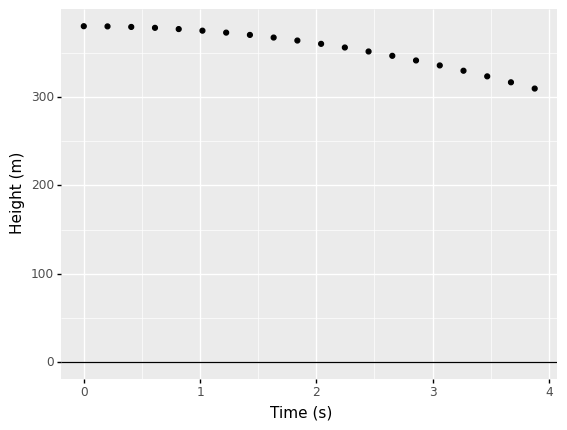

<ggplot: (8739120065862)>

In [2]:
df_penny = pd.read_csv("./data/penny.csv")

(
    df_penny
    >> ggplot(aes("t", "y"))
    + geom_point()
    + geom_hline(yintercept=0)
    + labs(
        x="Time (s)",
        y="Height (m)"
    )
)


### Model for projectile motion

Assume [Stokes drag](https://en.wikipedia.org/wiki/Projectile_motion#Displacement):

$$y(t) = y_0 - (g \tau) t + \tau (v_0 + g \tau) (1 - \exp(-t/\tau))$$

Implement as a Grama model:


In [3]:
g = 9.8 # Acceleration due to gravity
y0 = 380 # Height of empire state building
v0 = 0   # Initial velocity

md_penny = (
    gr.Model("Penny")
    >> gr.cp_vec_function(
        fun=lambda df: gr.df_make(
            y=y0 - g * df.tau * df.t + df.tau * (v0 + g * df.tau) * (1 - np.exp(-df.t / df.tau))
        ),
        var=["t", "tau"],
        out=["y"]
    )
    >> gr.cp_bounds(
        tau=(0, 100), # Time constant unknown
    )
)

md_penny.printpretty()


model: Penny

  inputs:
    var_det:
      t: (unbounded)
      tau: [0, 100]
    var_rand:
    copula:
        None
  functions:
    f0: ['t', 'tau'] -> ['y']


We don't know the quantity `tau`, but we have data: Use NLS to fit `tau`.


In [4]:
df_tau = gr.eval_nls(
    md_penny,
    df_data=df_penny,
)
df_tau

... eval_nls setting out = ['y']
... eval_nls setting var_fix = []
... eval_nls setting var_feat = ['t']


,tau
0,29.119542


Use this fitted value to evaluate the model and make a prediction


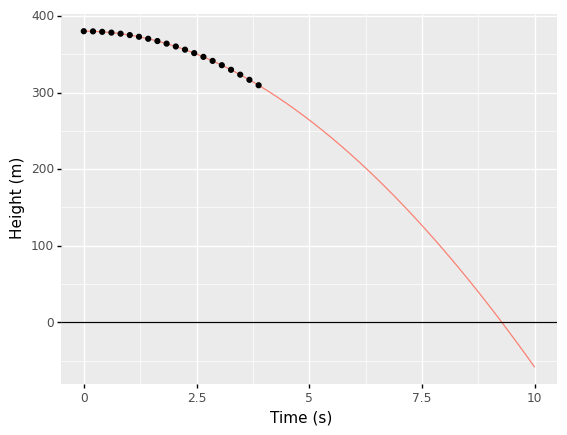

<ggplot: (8739115212078)>

In [9]:
df_predict = (
    md_penny
    >> gr.ev_df(
        df=gr.df_make(t=np.linspace(0, 10))
        >> gr.tf_outer(df_tau)
    )
)

(
    df_penny
    >> ggplot(aes("t", "y"))
    + geom_line(data=df_predict, color="salmon")
    + geom_point()
    + geom_hline(yintercept=0)
    + labs(
        x="Time (s)",
        y="Height (m)"
    )
)


## Math Formulation

---


## Grama Routines

---


## Coda: Ground-truth penny data

---


In [ ]:
g = 9.8 # Acceleration due to gravity, m/s^2

# Penny properties
Cd = 0.5    # Drag coefficient
rho = 1.205 # Density of air at STP, kg / m^3
A = 2.85e-4 # Cross-sectional area
m = 2.5e-3 # Mass of penny

# Stokes constant mu = 1 / tau
tau = (2 * m) / (Cd * rho * A)
print("tau_true = {}".format(tau))

# Trajectory with stokes drag
md_penny_true = (
    gr.Model("Penny: Ground-truth")
    >> gr.cp_vec_function(
        fun=lambda df: gr.df_make(
            y=df.y0 - g * tau * df.t + tau * (df.v0 + g * tau) * (1 - np.exp(-df.t / tau))
        ),
        var=["t", "v0", "y0"],
        out=["y"]
    )
)

# Generate some data
df_penny_true = (
    md_penny_true
    >> gr.ev_df(df=gr.df_make(v0=0, y0=380, t=np.linspace(0, 10, num=50)))
    >> gr.tf_filter(DF.y > 0)
)

# Save the first half of the data
df_penny_meas = df_penny_true.iloc[:20][["t", "y"]]
df_penny_meas.to_csv("./data/penny.csv", index=False)

# Visualize to check
(
    df_penny_measured
    >> ggplot(aes("t", "y"))
    + geom_point()
    + geom_point(
        data=df_penny_meas,
        color="salmon"
    )
)